<img src="gsstanim.gif" width=600 alt="ENSO"></img>

In [ ]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')

%matplotlib inline

In [10]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url)

In [11]:
ds = ds.sel(time=slice('1960', '2021'))

In [26]:
ds.sst.hvplot('lon', 'lat', cmap='Magma').redim.range(sst=(-2, 30))

:DynamicMap   [time]
   :Image   [lon,lat]   (sst)

In [15]:
sst_clim = ds.sst.groupby('time.month').mean(dim='time')
sst_anom = ds.sst.groupby('time.month') - sst_clim

In [17]:
from scipy.signal import detrend
sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom.fillna(0),
                                    kwargs={'axis': 0}).where(~sst_anom.isnull())

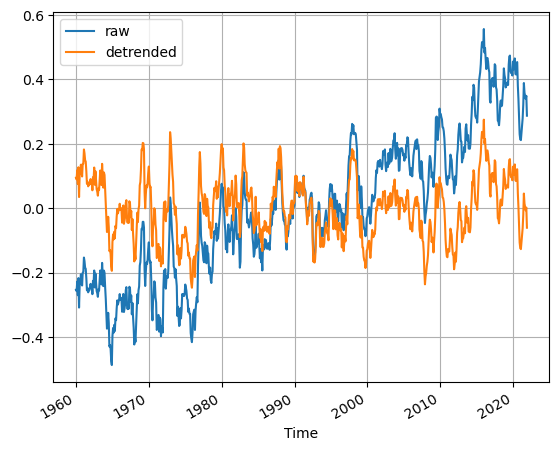

In [18]:
# For a global average, we need to weigh the points by cosine of latitude.
# This is not built into xarray because xarray is not specific to geoscientific data.
weights = np.cos(np.deg2rad(ds.lat)).where(~sst_anom[0].isnull())
weights /= weights.mean()

(sst_anom * weights).mean(dim=['lon', 'lat']).plot(label='raw')
(sst_anom_detrended * weights).mean(dim=['lon', 'lat']).plot(label='detrended')
plt.grid()
plt.legend()

In [19]:
sst_anom_detrended.hvplot('lon', 'lat', cmap='RdBu_r').redim.range(sst=(-2, 2))

:DynamicMap   [time]
   :Image   [lon,lat]   (sst)

In [20]:
sst_anom_nino34 = sst_anom_detrended.sel(lat=slice(5, -5), lon=slice(190, 240))
sst_anom_nino34_mean = sst_anom_nino34.mean(dim=('lon', 'lat'))
oni = sst_anom_nino34_mean.rolling(time=3, center=True).mean()

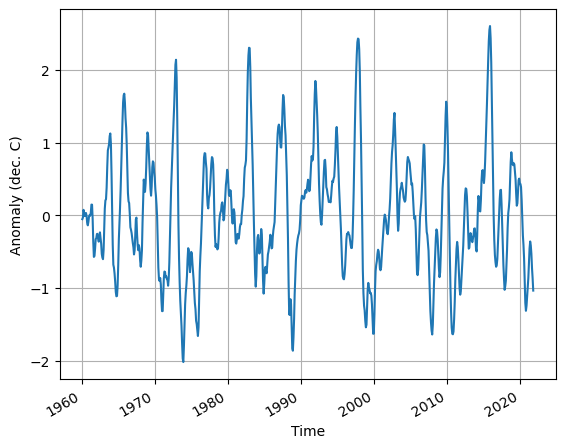

In [21]:
oni.plot()
plt.grid()
plt.ylabel('Anomaly (dec. C)');

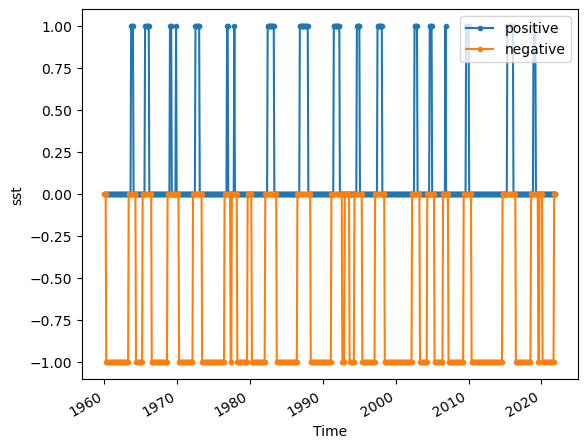

In [22]:
positive_oni = ((oni>0.5).astype('b').rolling(time=5, center=True).sum()==5)
negative_oni = ((oni<0.5).astype('b').rolling(time=5, center=True).sum()==5)
positive_oni.astype('i').plot(marker='.', label='positive')
(-negative_oni.astype('i')).plot(marker='.', label='negative')
plt.legend()

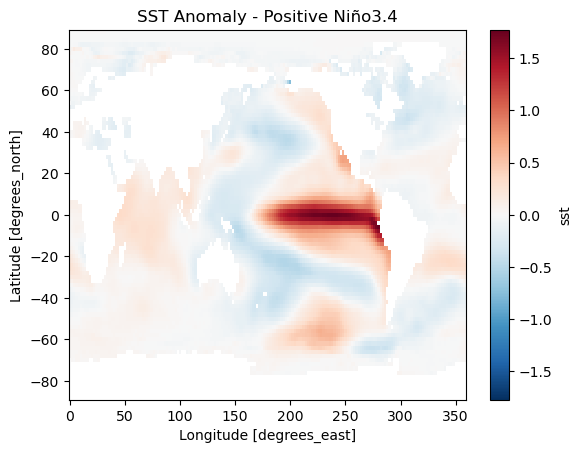

In [23]:
sst_anom.where(positive_oni).mean(dim='time').plot()
plt.title('SST Anomaly - Positive Niño3.4');

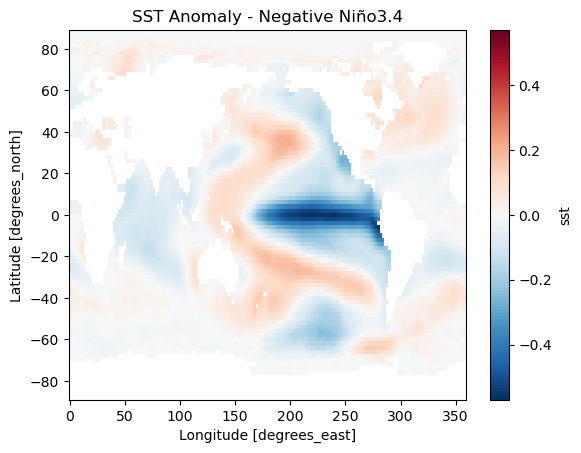

In [24]:
sst_anom.where(negative_oni).mean(dim='time').plot()
plt.title('SST Anomaly - Negative Niño3.4');